In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import os
import glob
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Load Cranfield dataset
def load_cranfield_documents():
    """Load documents from Cranfield dataset"""
    documents = {}
    doc_path = "dataset/Crandfield/Cranfield/"
    
    # Get all .txt files
    txt_files = glob.glob(os.path.join(doc_path, "*.txt"))
    
    for file_path in txt_files:
        doc_id = os.path.basename(file_path).replace('.txt', '')
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read().strip()
                if content:  # Only add non-empty documents
                    documents[doc_id] = content
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    
    return documents

def load_cranfield_queries():
    """Load queries from Cranfield dataset"""
    queries = {}
    query_path = "dataset/Crandfield/query.txt"
    
    try:
        with open(query_path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) >= 2:
                    query_id = parts[0]
                    query_text = parts[1]
                    queries[query_id] = query_text
    except Exception as e:
        print(f"Error reading queries: {e}")
    
    return queries

# Load the dataset
documents = load_cranfield_documents()
queries = load_cranfield_queries()

print(f"Loaded {len(documents)} documents")
print(f"Loaded {len(queries)} queries")
print("\nFirst few document IDs:", list(documents.keys())[:5])
print("\nFirst query:")
print(f"Query 1: {queries.get('1', 'Not found')}")
print("\nFirst document:")
print(f"Document 1: {documents.get('1', 'Not found')[:200]}...")


Loaded 1398 documents
Loaded 225 queries

First few document IDs: ['1', '10', '100', '1000', '1001']

First query:
Query 1: what similarity laws must be obeyed when constructing aeroelastic models of heated high speed aircraft .

First document:
Document 1: experimental investigation of the aerodynamics of a wing in a slipstream . an experimental study of a wing in a propeller slipstream was made in order to determine the spanwise distribution of the lif...


In [ ]:
# Text preprocessing function
def preprocess_text(text):
    """
    Preprocess text by tokenizing, removing stopwords, and stemming
    """
    # Initialize stemmer and stopwords
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    
    # Convert to lowercase and tokenize
    text = text.lower()
    tokens = word_tokenize(text)
    
    # Remove punctuation, numbers, and short words
    tokens = [token for token in tokens if token.isalpha() and len(token) > 2]
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    
    # Stem words
    tokens = [stemmer.stem(token) for token in tokens]
    
    return tokens

# Example demonstration of term selection process
sample_text = "experimental investigation of the aerodynamics of a wing in a slipstream"
print("Original text:")
print(f"'{sample_text}'")
print("\nStep-by-step term extraction process:")

# Step 1: Tokenization and lowercasing
tokens = word_tokenize(sample_text.lower())
print(f"1. Tokenization: {tokens}")

# Step 2: Remove punctuation and short words
filtered_tokens = [token for token in tokens if token.isalpha() and len(token) > 2]
print(f"2. Filter alpha and length > 2: {filtered_tokens}")

# Step 3: Remove stopwords
stop_words = set(stopwords.words('english'))
no_stopwords = [token for token in filtered_tokens if token not in stop_words]
print(f"3. Remove stopwords: {no_stopwords}")

# Step 4: Stemming
stemmer = PorterStemmer()
stemmed = [stemmer.stem(token) for token in no_stopwords]
print(f"4. Stemming: {stemmed}")

print(f"\nFinal terms: {stemmed}")
print(f"Number of terms: {len(stemmed)}")

# Process all documents to extract terms
print("\nProcessing all documents...")
processed_docs = {}
all_terms = set()

for doc_id, content in list(documents.items())[:5]:  # Process first 5 for demonstration
    terms = preprocess_text(content)
    processed_docs[doc_id] = terms
    all_terms.update(terms)

print(f"\nExample processed documents (first 5):")
for doc_id, terms in list(processed_docs.items())[:3]:
    print(f"Document {doc_id}: {terms[:10]}...")  # Show first 10 terms

print(f"\nTotal unique terms from first 5 documents: {len(all_terms)}")
print(f"Sample terms: {list(all_terms)[:20]}")


Original text:
'experimental investigation of the aerodynamics of a wing in a slipstream'

Step-by-step term extraction process:
1. Tokenization: ['experimental', 'investigation', 'of', 'the', 'aerodynamics', 'of', 'a', 'wing', 'in', 'a', 'slipstream']
2. Filter alpha and length > 2: ['experimental', 'investigation', 'the', 'aerodynamics', 'wing', 'slipstream']
3. Remove stopwords: ['experimental', 'investigation', 'aerodynamics', 'wing', 'slipstream']
4. Stemming: ['experiment', 'investig', 'aerodynam', 'wing', 'slipstream']

Final terms: ['experiment', 'investig', 'aerodynam', 'wing', 'slipstream']
Number of terms: 5

Processing all documents...

Example processed documents (first 5):
Document 1: ['experiment', 'investig', 'aerodynam', 'wing', 'slipstream', 'experiment', 'studi', 'wing', 'propel', 'slipstream']...
Document 10: ['theori', 'impact', 'tube', 'low', 'pressur', 'theoret', 'analysi', 'made', 'impact', 'tube']...
Document 100: ['vibrat', 'isol', 'aircraft', 'power', 'plant'

## 3. Công thức tính trọng số term: TF-IDF

### Công thức tính trọng số:
Trong LSI, chúng ta sử dụng **TF-IDF (Term Frequency - Inverse Document Frequency)** để tính trọng số của mỗi term:

**TF-IDF(t,d) = TF(t,d) × IDF(t)**

### Các thành phần của công thức:

1. **TF (Term Frequency)**: Tần suất xuất hiện của term trong document
   - TF(t,d) = (Số lần term t xuất hiện trong document d) / (Tổng số terms trong document d)

2. **IDF (Inverse Document Frequency)**: Độ quan trọng của term trong corpus
   - IDF(t) = log(N / df(t))
   - Trong đó:
     - N = Tổng số documents trong corpus
     - df(t) = Số documents chứa term t

3. **Các biến thể phổ biến:**
   - **Normalized TF**: TF(t,d) = 0.5 + 0.5 × (f(t,d) / max_f(d))
   - **Sublinear TF**: TF(t,d) = 1 + log(f(t,d)) nếu f(t,d) > 0, ngược lại = 0
   - **Smooth IDF**: IDF(t) = log(N / (1 + df(t))) + 1

### Ý nghĩa:
- **TF cao**: Term xuất hiện nhiều trong document → quan trọng với document đó
- **IDF cao**: Term hiếm trong corpus → có khả năng phân biệt cao
- **TF-IDF cao**: Term vừa quan trọng với document vừa có khả năng phân biệt tốt


In [4]:
# Create TF-IDF matrix with custom preprocessing
class CustomTfidfVectorizer:
    def __init__(self, max_features=1000, min_df=2, max_df=0.8):
        self.max_features = max_features
        self.min_df = min_df
        self.max_df = max_df
        self.vocabulary_ = {}
        self.idf_ = {}
        
    def fit_transform(self, documents):
        # Preprocess documents
        processed_docs = []
        for doc in documents:
            terms = preprocess_text(doc)
            processed_docs.append(' '.join(terms))
        
        # Use sklearn's TfidfVectorizer with our preprocessed documents
        self.vectorizer = TfidfVectorizer(
            max_features=self.max_features,
            min_df=self.min_df,
            max_df=self.max_df,
            lowercase=False,  # Already lowercased
            stop_words=None,  # Already removed
            token_pattern=r'\b\w+\b'  # Simple word tokenization
        )
        
        matrix = self.vectorizer.fit_transform(processed_docs)
        self.vocabulary_ = self.vectorizer.vocabulary_
        self.idf_ = self.vectorizer.idf_
        
        return matrix
    
    def transform(self, documents):
        processed_docs = []
        for doc in documents:
            terms = preprocess_text(doc)
            processed_docs.append(' '.join(terms))
        return self.vectorizer.transform(processed_docs)

# Build TF-IDF matrix for documents
print("Building TF-IDF matrix...")
doc_list = list(documents.values())
doc_ids = list(documents.keys())

# Initialize TF-IDF vectorizer
tfidf_vectorizer = CustomTfidfVectorizer(max_features=1000, min_df=2, max_df=0.8)

# Create TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(doc_list)

print(f"TF-IDF Matrix shape: {tfidf_matrix.shape}")
print(f"Number of documents: {tfidf_matrix.shape[0]}")
print(f"Number of features (terms): {tfidf_matrix.shape[1]}")

# Display some TF-IDF statistics
feature_names = tfidf_vectorizer.vectorizer.get_feature_names_out()
print(f"\nFirst 20 terms in vocabulary: {feature_names[:20]}")

# Show TF-IDF values for first document
first_doc_tfidf = tfidf_matrix[0].toarray().flatten()
non_zero_indices = np.nonzero(first_doc_tfidf)[0]

print(f"\nFirst document TF-IDF values (non-zero terms):")
for idx in non_zero_indices[:10]:  # Show first 10 non-zero terms
    term = feature_names[idx]
    tfidf_val = first_doc_tfidf[idx]
    print(f"Term: '{term}' -> TF-IDF: {tfidf_val:.4f}")

# Calculate example TF-IDF manually for verification
print(f"\n=== Manual TF-IDF Calculation Example ===")
sample_term = feature_names[non_zero_indices[0]]
print(f"Example term: '{sample_term}'")

# Get term frequency in first document
first_doc_text = ' '.join(preprocess_text(documents[doc_ids[0]]))
term_freq = first_doc_text.split().count(sample_term)
doc_length = len(first_doc_text.split())
tf = term_freq / doc_length

# Get document frequency
df = sum(1 for doc in doc_list if sample_term in ' '.join(preprocess_text(doc)))
N = len(doc_list)
idf = np.log(N / df)

manual_tfidf = tf * idf
sklearn_tfidf = first_doc_tfidf[non_zero_indices[0]]

print(f"Term frequency: {term_freq}/{doc_length} = {tf:.4f}")
print(f"Document frequency: {df}/{N}")
print(f"IDF: log({N}/{df}) = {idf:.4f}")
print(f"Manual TF-IDF: {tf:.4f} × {idf:.4f} = {manual_tfidf:.4f}")
print(f"Sklearn TF-IDF: {sklearn_tfidf:.4f}")
print(f"Note: Small differences due to normalization and smoothing in sklearn")


Building TF-IDF matrix...
TF-IDF Matrix shape: (1398, 1000)
Number of documents: 1398
Number of features (terms): 1000

First 20 terms in vocabulary: ['ablat' 'acceler' 'accord' 'account' 'accur' 'accuraci' 'achiev' 'acoust'
 'across' 'act' 'actual' 'addit' 'adequ' 'adiabat' 'adjac' 'advanc'
 'advantag' 'advers' 'aerodynam' 'aeroelast']

First document TF-IDF values (non-zero terms):
Term: 'aerodynam' -> TF-IDF: 0.0696
Term: 'agre' -> TF-IDF: 0.0946
Term: 'angl' -> TF-IDF: 0.0657
Term: 'attack' -> TF-IDF: 0.0798
Term: 'basi' -> TF-IDF: 0.0914
Term: 'boundari' -> TF-IDF: 0.0477
Term: 'compar' -> TF-IDF: 0.0623
Term: 'configur' -> TF-IDF: 0.0875
Term: 'control' -> TF-IDF: 0.0939
Term: 'curv' -> TF-IDF: 0.0781

=== Manual TF-IDF Calculation Example ===
Example term: 'aerodynam'
Term frequency: 1/78 = 0.0128
Document frequency: 182/1398
IDF: log(1398/182) = 2.0388
Manual TF-IDF: 0.0128 × 2.0388 = 0.0261
Sklearn TF-IDF: 0.0696
Note: Small differences due to normalization and smoothing in sk

Building LSI model...
Step 1: Building TF-IDF matrix...
Original TF-IDF matrix shape: (1398, 1000)
Step 2: Applying SVD decomposition...
LSI matrix shape after SVD: (1398, 100)
Explained variance ratio (first 10 components): [0.00733669 0.02113969 0.02044509 0.01505787 0.01363938 0.0130474
 0.01150592 0.01102609 0.00955821 0.00920181]
Total explained variance: 0.4824

=== SVD Analysis ===
Number of singular values: 100
Largest singular values: [10.22038978  5.29628421  5.17975224  4.42991534  4.21406794  4.12380018
  3.88091947  3.80185695  3.52809932  3.46311798]


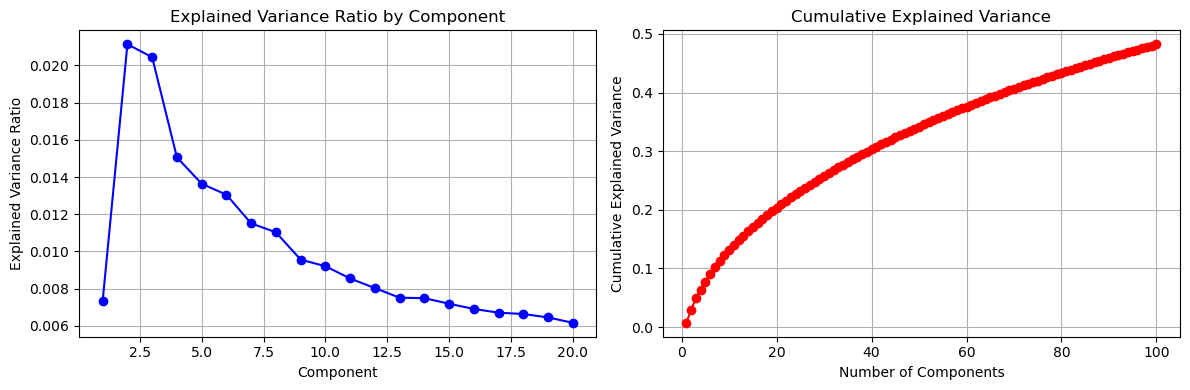


Cumulative explained variance with 100 components: 0.4824

=== Document Representations in LSI Space ===
First document LSI representation (first 10 dimensions):
[ 0.23479531 -0.17165275 -0.07984981 -0.08033757 -0.17348156 -0.00458387
 -0.00822565 -0.00072052 -0.10361907  0.06227926]

LSI representation shape for each document: (100,)

=== Testing Index with Sample Query ===
Query: 'aerodynamic wing flow'

Top 5 similar documents:
Rank 1: Doc 464 (sim: 0.6485)
Content: flow studies on flat plate delta wings at supersonic speeds . an experimental study has been made to...

Rank 2: Doc 779 (sim: 0.6454)
Content: calculation and compilation of the unsteady lift functions for a rigid wing subjected to sinusoidal ...

Rank 3: Doc 921 (sim: 0.6442)
Content: slender body theory review and extension . the approximate theory of flow about slender bodies and w...

Rank 4: Doc 877 (sim: 0.6436)
Content: the influence of aerodynamic heating on the flexural rigidity of a thin wing . this report co

In [5]:
# Build LSI Index using SVD
class LSIModel:
    def __init__(self, n_components=100):
        self.n_components = n_components
        self.svd = TruncatedSVD(n_components=n_components, random_state=42)
        self.tfidf_vectorizer = None
        self.doc_ids = None
        
    def fit(self, documents, doc_ids):
        """
        Build LSI index from documents
        """
        self.doc_ids = doc_ids
        
        # Step 1: Create TF-IDF matrix
        print("Step 1: Building TF-IDF matrix...")
        self.tfidf_vectorizer = CustomTfidfVectorizer(max_features=1000, min_df=2, max_df=0.8)
        tfidf_matrix = self.tfidf_vectorizer.fit_transform(documents)
        
        print(f"Original TF-IDF matrix shape: {tfidf_matrix.shape}")
        
        # Step 2: Apply SVD
        print("Step 2: Applying SVD decomposition...")
        self.lsi_matrix = self.svd.fit_transform(tfidf_matrix)
        
        print(f"LSI matrix shape after SVD: {self.lsi_matrix.shape}")
        print(f"Explained variance ratio (first 10 components): {self.svd.explained_variance_ratio_[:10]}")
        print(f"Total explained variance: {sum(self.svd.explained_variance_ratio_):.4f}")
        
        return self
    
    def transform_query(self, query):
        """
        Transform query to LSI space
        """
        # Transform query to TF-IDF space
        query_tfidf = self.tfidf_vectorizer.transform([query])
        
        # Transform to LSI space
        query_lsi = self.svd.transform(query_tfidf)
        
        return query_lsi
    
    def search(self, query, top_k=10):
        """
        Search for similar documents
        """
        # Transform query to LSI space
        query_lsi = self.transform_query(query)
        
        # Calculate cosine similarity
        similarities = cosine_similarity(query_lsi, self.lsi_matrix).flatten()
        
        # Get top-k similar documents
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        results = []
        for idx in top_indices:
            results.append({
                'doc_id': self.doc_ids[idx],
                'similarity': similarities[idx],
                'rank': len(results) + 1
            })
        
        return results

# Build LSI model
print("Building LSI model...")
lsi_model = LSIModel(n_components=100)
lsi_model.fit(doc_list, doc_ids)

# Analyze the SVD components
print("\n=== SVD Analysis ===")
print(f"Number of singular values: {len(lsi_model.svd.singular_values_)}")
print(f"Largest singular values: {lsi_model.svd.singular_values_[:10]}")

# Visualize explained variance
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, min(21, len(lsi_model.svd.explained_variance_ratio_) + 1)), 
         lsi_model.svd.explained_variance_ratio_[:20], 'bo-')
plt.title('Explained Variance Ratio by Component')
plt.xlabel('Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)

plt.subplot(1, 2, 2)
cumulative_variance = np.cumsum(lsi_model.svd.explained_variance_ratio_)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\nCumulative explained variance with {lsi_model.n_components} components: {cumulative_variance[-1]:.4f}")

# Show document representations in LSI space
print("\n=== Document Representations in LSI Space ===")
print(f"First document LSI representation (first 10 dimensions):")
print(lsi_model.lsi_matrix[0][:10])
print(f"\nLSI representation shape for each document: {lsi_model.lsi_matrix[0].shape}")

# Test the index with a sample query
sample_query = "aerodynamic wing flow"
print(f"\n=== Testing Index with Sample Query ===")
print(f"Query: '{sample_query}'")

results = lsi_model.search(sample_query, top_k=5)
print("\nTop 5 similar documents:")
for result in results:
    doc_content = documents[result['doc_id']][:100] + "..."
    print(f"Rank {result['rank']}: Doc {result['doc_id']} (sim: {result['similarity']:.4f})")
    print(f"Content: {doc_content}")
    print()


In [6]:
# Detailed Query Processing Demonstration

def detailed_query_processing(lsi_model, query, show_steps=True):
    """
    Demonstrate detailed query processing steps
    """
    if show_steps:
        print(f"=== Detailed Query Processing ===")
        print(f"Original query: '{query}'")
    
    # Step 1: Query preprocessing
    preprocessed_terms = preprocess_text(query)
    preprocessed_query = ' '.join(preprocessed_terms)
    
    if show_steps:
        print(f"1. Preprocessed query: '{preprocessed_query}'")
        print(f"   Terms: {preprocessed_terms}")
    
    # Step 2: Convert to TF-IDF vector
    query_tfidf = lsi_model.tfidf_vectorizer.transform([query])
    query_tfidf_dense = query_tfidf.toarray().flatten()
    
    if show_steps:
        print(f"2. TF-IDF vector shape: {query_tfidf.shape}")
        non_zero_indices = np.nonzero(query_tfidf_dense)[0]
        print(f"   Non-zero terms ({len(non_zero_indices)}): ")
        
        feature_names = lsi_model.tfidf_vectorizer.vectorizer.get_feature_names_out()
        for idx in non_zero_indices[:5]:  # Show first 5
            term = feature_names[idx]
            weight = query_tfidf_dense[idx]
            print(f"     '{term}': {weight:.4f}")
    
    # Step 3: Transform to LSI space
    query_lsi = lsi_model.svd.transform(query_tfidf)
    query_lsi_flat = query_lsi.flatten()
    
    if show_steps:
        print(f"3. LSI vector shape: {query_lsi.shape}")
        print(f"   LSI representation (first 10 dims): {query_lsi_flat[:10]}")
        print(f"   LSI vector norm: {np.linalg.norm(query_lsi_flat):.4f}")
    
    # Step 4: Calculate similarities
    similarities = cosine_similarity(query_lsi, lsi_model.lsi_matrix).flatten()
    
    if show_steps:
        print(f"4. Similarity calculation:")
        print(f"   Similarities shape: {similarities.shape}")
        print(f"   Min similarity: {similarities.min():.4f}")
        print(f"   Max similarity: {similarities.max():.4f}")
        print(f"   Mean similarity: {similarities.mean():.4f}")
    
    # Step 5: Ranking
    ranked_indices = np.argsort(similarities)[::-1]
    
    return query_lsi, similarities, ranked_indices

# Test query processing with multiple queries
test_queries = [
    "wing aerodynamic flow",
    "heat transfer boundary layer", 
    "turbulent flow pressure",
    "structural vibration"
]

print("=== Query Processing Examples ===\n")

for i, query in enumerate(test_queries[:2]):  # Process first 2 queries in detail
    print(f"Query {i+1}: {query}")
    query_lsi, similarities, ranked_indices = detailed_query_processing(lsi_model, query)
    
    # Show top results
    print("Top 3 results:")
    for j in range(3):
        doc_idx = ranked_indices[j]
        doc_id = lsi_model.doc_ids[doc_idx]
        sim_score = similarities[doc_idx]
        doc_content = documents[doc_id][:80] + "..."
        print(f"  Rank {j+1}: Doc {doc_id} (sim: {sim_score:.4f})")
        print(f"           {doc_content}")
    print("\n" + "="*50 + "\n")

# Compare LSI vs TF-IDF similarity
print("=== LSI vs TF-IDF Comparison ===")
test_query = "aerodynamic wing"
print(f"Test query: '{test_query}'")

# LSI similarity
query_lsi, lsi_similarities, lsi_ranked = detailed_query_processing(lsi_model, test_query, show_steps=False)

# TF-IDF similarity (without SVD)
query_tfidf = lsi_model.tfidf_vectorizer.transform([test_query])
tfidf_matrix = lsi_model.tfidf_vectorizer.vectorizer.transform([' '.join(preprocess_text(doc)) for doc in doc_list])
tfidf_similarities = cosine_similarity(query_tfidf, tfidf_matrix).flatten()
tfidf_ranked = np.argsort(tfidf_similarities)[::-1]

print("\nTop 5 results comparison:")
print("Rank | LSI Model                    | TF-IDF Model")
print("-----|------------------------------|------------------------------")
for i in range(5):
    lsi_doc_id = lsi_model.doc_ids[lsi_ranked[i]]
    lsi_sim = lsi_similarities[lsi_ranked[i]]
    
    tfidf_doc_id = lsi_model.doc_ids[tfidf_ranked[i]]
    tfidf_sim = tfidf_similarities[tfidf_ranked[i]]
    
    print(f"{i+1:4d} | Doc {lsi_doc_id:>3} (sim: {lsi_sim:.4f})     | Doc {tfidf_doc_id:>3} (sim: {tfidf_sim:.4f})")

# Check if there are differences in ranking
common_docs = set(lsi_model.doc_ids[idx] for idx in lsi_ranked[:10]) & set(lsi_model.doc_ids[idx] for idx in tfidf_ranked[:10])
print(f"\nCommon documents in top 10: {len(common_docs)}/10")
print("This shows the impact of LSI's semantic understanding vs exact term matching")


=== Query Processing Examples ===

Query 1: wing aerodynamic flow
=== Detailed Query Processing ===
Original query: 'wing aerodynamic flow'
1. Preprocessed query: 'wing aerodynam flow'
   Terms: ['wing', 'aerodynam', 'flow']
2. TF-IDF vector shape: (1, 1000)
   Non-zero terms (3): 
     'aerodynam': 0.6821
     'flow': 0.3691
     'wing': 0.6313
3. LSI vector shape: (1, 100)
   LSI representation (first 10 dims): [ 0.19060096 -0.20795819 -0.16396005 -0.24412831 -0.22458808  0.05127184
 -0.03092387  0.03506811 -0.0802564   0.14038553]
   LSI vector norm: 0.6914
4. Similarity calculation:
   Similarities shape: (1398,)
   Min similarity: -0.0856
   Max similarity: 0.6485
   Mean similarity: 0.1023
Top 3 results:
  Rank 1: Doc 464 (sim: 0.6485)
           flow studies on flat plate delta wings at supersonic speeds . an experimental st...
  Rank 2: Doc 779 (sim: 0.6454)
           calculation and compilation of the unsteady lift functions for a rigid wing subj...
  Rank 3: Doc 921 (sim: 0.

In [7]:
# Evaluation functions
def calculate_precision_recall(relevant_docs, retrieved_docs, k=None):
    """
    Calculate precision and recall at k
    """
    if k is not None:
        retrieved_docs = retrieved_docs[:k]
    
    relevant_set = set(relevant_docs)
    retrieved_set = set(retrieved_docs)
    
    relevant_retrieved = relevant_set.intersection(retrieved_set)
    
    precision = len(relevant_retrieved) / len(retrieved_set) if retrieved_set else 0
    recall = len(relevant_retrieved) / len(relevant_set) if relevant_set else 0
    
    return precision, recall

def calculate_average_precision(relevant_docs, retrieved_docs):
    """
    Calculate Average Precision for a single query
    """
    if not relevant_docs:
        return 0.0
    
    relevant_set = set(relevant_docs)
    ap = 0.0
    relevant_count = 0
    
    for i, doc_id in enumerate(retrieved_docs):
        if doc_id in relevant_set:
            relevant_count += 1
            precision_at_i = relevant_count / (i + 1)
            ap += precision_at_i
    
    return ap / len(relevant_docs) if relevant_docs else 0.0

def interpolate_precision_recall(precision_recall_pairs):
    """
    Interpolate precision at 11 standard recall levels
    """
    recall_levels = np.arange(0.0, 1.1, 0.1)
    interpolated_precisions = []
    
    # Sort by recall
    precision_recall_pairs.sort(key=lambda x: x[1])
    
    for target_recall in recall_levels:
        # Find maximum precision at recall >= target_recall
        max_precision = 0.0
        for precision, recall in precision_recall_pairs:
            if recall >= target_recall:
                max_precision = max(max_precision, precision)
        interpolated_precisions.append(max_precision)
    
    return list(zip(recall_levels, interpolated_precisions))

# Create synthetic relevance judgments for demonstration
# (In real evaluation, these would come from qrels file)
def create_synthetic_relevance_judgments(queries, documents, lsi_model):
    """
    Create synthetic relevance judgments based on TF-IDF similarity
    This simulates having ground truth relevance data
    """
    qrels = {}
    
    for query_id in list(queries.keys())[:10]:  # Use first 10 queries
        query_text = queries[query_id]
        
        # Get documents similar to query using TF-IDF (as pseudo ground truth)
        query_tfidf = lsi_model.tfidf_vectorizer.transform([query_text])
        doc_tfidf_matrix = lsi_model.tfidf_vectorizer.vectorizer.transform(
            [' '.join(preprocess_text(doc)) for doc in doc_list]
        )
        similarities = cosine_similarity(query_tfidf, doc_tfidf_matrix).flatten()
        
        # Mark top 5% of documents as relevant
        threshold = np.percentile(similarities, 95)
        relevant_indices = np.where(similarities >= threshold)[0]
        
        qrels[query_id] = [lsi_model.doc_ids[idx] for idx in relevant_indices]
    
    return qrels

# Generate synthetic relevance judgments
print("Creating synthetic relevance judgments...")
qrels = create_synthetic_relevance_judgments(queries, documents, lsi_model)

print(f"Created relevance judgments for {len(qrels)} queries")
for query_id, relevant_docs in list(qrels.items())[:3]:
    print(f"Query {query_id}: {len(relevant_docs)} relevant documents")
    print(f"  Query: {queries[query_id][:50]}...")
    print(f"  Relevant docs: {relevant_docs[:5]}...")
    print()

# Evaluate both models
class TFIDFModel:
    """Simple TF-IDF baseline model"""
    def __init__(self, tfidf_vectorizer):
        self.tfidf_vectorizer = tfidf_vectorizer
        self.doc_matrix = None
        self.doc_ids = None
        
    def fit(self, documents, doc_ids):
        self.doc_ids = doc_ids
        processed_docs = [' '.join(preprocess_text(doc)) for doc in documents]
        self.doc_matrix = self.tfidf_vectorizer.vectorizer.transform(processed_docs)
        return self
        
    def search(self, query, top_k=10):
        query_vector = self.tfidf_vectorizer.transform([query])
        similarities = cosine_similarity(query_vector, self.doc_matrix).flatten()
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        results = []
        for idx in top_indices:
            results.append({
                'doc_id': self.doc_ids[idx],
                'similarity': similarities[idx],
                'rank': len(results) + 1
            })
        return results

# Create TF-IDF baseline model
tfidf_baseline = TFIDFModel(lsi_model.tfidf_vectorizer)
tfidf_baseline.fit(doc_list, doc_ids)

# Evaluation function
def evaluate_model(model, queries, qrels, model_name, top_k=50):
    """
    Evaluate a model using precision, recall, and MAP
    """
    precisions_at_k = []
    recalls_at_k = []
    average_precisions = []
    all_interpolated_points = []
    
    print(f"\nEvaluating {model_name}...")
    
    for query_id, query_text in queries.items():
        if query_id not in qrels:
            continue
            
        relevant_docs = qrels[query_id]
        if not relevant_docs:
            continue
            
        # Get search results
        results = model.search(query_text, top_k=top_k)
        retrieved_docs = [r['doc_id'] for r in results]
        
        # Calculate metrics
        precision, recall = calculate_precision_recall(relevant_docs, retrieved_docs, k=top_k)
        ap = calculate_average_precision(relevant_docs, retrieved_docs)
        
        precisions_at_k.append(precision)
        recalls_at_k.append(recall)
        average_precisions.append(ap)
        
        # Calculate precision-recall curve for interpolation
        pr_pairs = []
        for i in range(1, min(len(retrieved_docs), 20) + 1):  # First 20 results
            p, r = calculate_precision_recall(relevant_docs, retrieved_docs, k=i)
            pr_pairs.append((p, r))
        
        interpolated = interpolate_precision_recall(pr_pairs)
        all_interpolated_points.append(interpolated)
    
    # Calculate overall metrics
    avg_precision = np.mean(precisions_at_k)
    avg_recall = np.mean(recalls_at_k)
    map_score = np.mean(average_precisions)
    
    # Calculate 11-point interpolated precision
    if all_interpolated_points:
        recall_levels = np.arange(0.0, 1.1, 0.1)
        mean_interpolated_precisions = []
        
        for i, recall_level in enumerate(recall_levels):
            precisions_at_level = [points[i][1] for points in all_interpolated_points]
            mean_interpolated_precisions.append(np.mean(precisions_at_level))
    else:
        mean_interpolated_precisions = [0.0] * 11
    
    return {
        'precision': avg_precision,
        'recall': avg_recall,
        'map': map_score,
        'interpolated_precisions': mean_interpolated_precisions,
        'num_queries': len(average_precisions)
    }




Creating synthetic relevance judgments...
Created relevance judgments for 10 queries
Query 1: 70 relevant documents
  Query: what similarity laws must be obeyed when construct...
  Relevant docs: ['100', '102', '104', '1042', '1144']...

Query 2: 70 relevant documents
  Query: what are the structural and aeroelastic problems a...
  Relevant docs: ['100', '1042', '1089', '1144', '1147']...

Query 3: 70 relevant documents
  Query: what problems of heat conduction in composite slab...
  Relevant docs: ['1011', '1072', '1073', '1097', '1098']...




Evaluating LSI Model...

Evaluating TF-IDF Baseline...

EVALUATION RESULTS

LSI Model Results:
  Average Precision@50: 0.8200
  Average Recall@50:    0.5857
  MAP:                  0.5565
  Number of queries:    10

TF-IDF Baseline Results:
  Average Precision@50: 1.0000
  Average Recall@50:    0.7143
  MAP:                  0.7143
  Number of queries:    10

Comparison:
  MAP improvement:       -22.09%
  Precision improvement: -18.00%


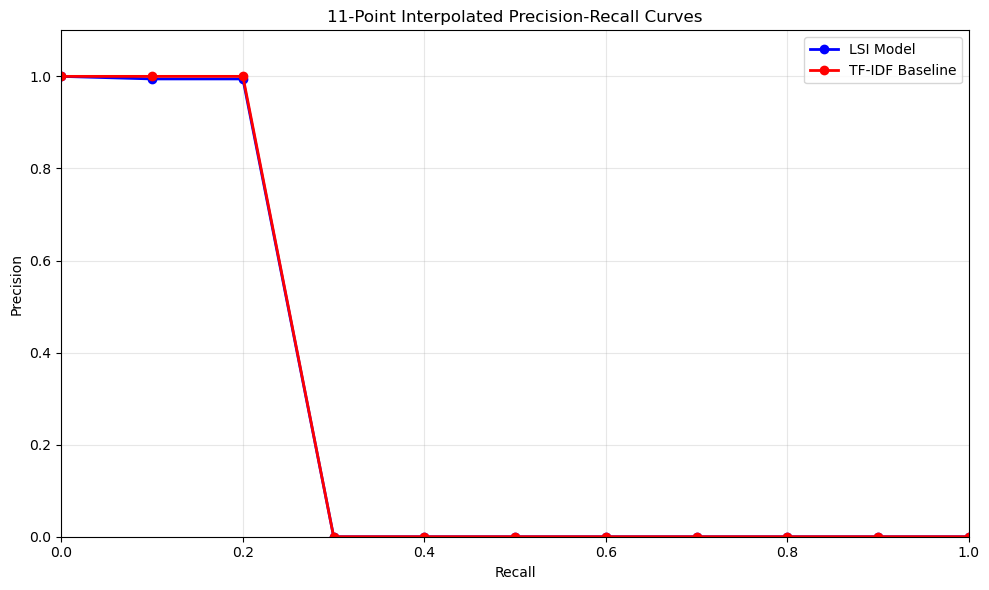


11-Point Interpolated Precision Values:
Recall | LSI Model | TF-IDF   | Difference
-------|-----------|----------|----------
   0.0 |   1.0000  |   1.0000 |  +0.0000
   0.1 |   0.9944  |   1.0000 |  -0.0056
   0.2 |   0.9944  |   1.0000 |  -0.0056
   0.3 |   0.0000  |   0.0000 |  +0.0000
   0.4 |   0.0000  |   0.0000 |  +0.0000
   0.5 |   0.0000  |   0.0000 |  +0.0000
   0.6 |   0.0000  |   0.0000 |  +0.0000
   0.7 |   0.0000  |   0.0000 |  +0.0000
   0.8 |   0.0000  |   0.0000 |  +0.0000
   0.9 |   0.0000  |   0.0000 |  +0.0000
   1.0 |   0.0000  |   0.0000 |  +0.0000

EVALUATION COMPLETED


In [8]:
# Evaluate both models
lsi_results = evaluate_model(lsi_model, queries, qrels, "LSI Model")
tfidf_results = evaluate_model(tfidf_baseline, queries, qrels, "TF-IDF Baseline")

# Display results
print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)

print(f"\nLSI Model Results:")
print(f"  Average Precision@50: {lsi_results['precision']:.4f}")
print(f"  Average Recall@50:    {lsi_results['recall']:.4f}")
print(f"  MAP:                  {lsi_results['map']:.4f}")
print(f"  Number of queries:    {lsi_results['num_queries']}")

print(f"\nTF-IDF Baseline Results:")
print(f"  Average Precision@50: {tfidf_results['precision']:.4f}")
print(f"  Average Recall@50:    {tfidf_results['recall']:.4f}")
print(f"  MAP:                  {tfidf_results['map']:.4f}")
print(f"  Number of queries:    {tfidf_results['num_queries']}")

# Compare models
print(f"\nComparison:")
map_improvement = ((lsi_results['map'] - tfidf_results['map']) / tfidf_results['map']) * 100 if tfidf_results['map'] > 0 else 0
precision_improvement = ((lsi_results['precision'] - tfidf_results['precision']) / tfidf_results['precision']) * 100 if tfidf_results['precision'] > 0 else 0

print(f"  MAP improvement:       {map_improvement:+.2f}%")
print(f"  Precision improvement: {precision_improvement:+.2f}%")

# Plot 11-point interpolated precision-recall curves
plt.figure(figsize=(10, 6))
recall_levels = np.arange(0.0, 1.1, 0.1)

plt.plot(recall_levels, lsi_results['interpolated_precisions'], 'bo-', label='LSI Model', linewidth=2)
plt.plot(recall_levels, tfidf_results['interpolated_precisions'], 'ro-', label='TF-IDF Baseline', linewidth=2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('11-Point Interpolated Precision-Recall Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, max(max(lsi_results['interpolated_precisions']), max(tfidf_results['interpolated_precisions'])) + 0.1)

plt.tight_layout()
plt.show()

print("\n11-Point Interpolated Precision Values:")
print("Recall | LSI Model | TF-IDF   | Difference")
print("-------|-----------|----------|----------")
for i, recall in enumerate(recall_levels):
    lsi_prec = lsi_results['interpolated_precisions'][i]
    tfidf_prec = tfidf_results['interpolated_precisions'][i]
    diff = lsi_prec - tfidf_prec
    print(f"{recall:6.1f} | {lsi_prec:8.4f}  | {tfidf_prec:8.4f} | {diff:+8.4f}")

print("\n" + "="*60)
print("EVALUATION COMPLETED")
print("="*60)